<a href="https://colab.research.google.com/github/ishaanpaul98/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports #

In [57]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import datetime
import yfinance as yf
import time
import requests
import io

In [58]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [60]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from sklearn.metrics import plot_confusion_matrix

# Stock Data Helper Functions #

In [61]:
def getStockDataDaily(symbol, day):
    print("Getting stock data for stock $"+symbol)
    df = yf.download(symbol, start=day, period = "1d")
    return df

getStockDataDaily('AAPL', "2022-12-21")

Getting stock data for stock $AAPL
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-21,132.979996,136.809998,132.750000,135.449997,135.449997,85928000
2022-12-22,134.350006,134.559998,130.300003,132.229996,132.229996,77852100
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.860001,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,130.029999,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,126.040001,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.610001,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.929993,76960600
2023-01-03,130.279999,130.899994,124.169998,125.070000,125.070000,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,126.360001,89113600


In [62]:
def arrayToString(arr):
    print("Starting array to list")
    listToStr = ' '.join([str(elem) for elem in arr])
    return listToStr


In [63]:
def getMultiStockDataDaily(symbols, day):
    if len(symbols) > 1:
        print("Length of symbols array is more than 1. STARTING ARRAYTOSTRING")
        symbols = arrayToString(symbols)
    print("Getting stock data for stock $"+symbols)
    df = yf.download(symbols, start=day, period = "1d", group_by='ticker')
    return df

getMultiStockDataDaily(['AAPL', 'TSLA'], "2022-12-21")

Length of symbols array is more than 1. STARTING ARRAYTOSTRING
Starting array to list
Getting stock data for stock $AAPL TSLA
[*********************100%***********************]  2 of 2 completed


TSLA                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2022-12-21  139.339996  141.259995  135.889999  137.570007  137.570007   
2022-12-22  136.000000  136.630005  122.260002  125.349998  125.349998   
2022-12-23  126.370003  128.619995  121.019997  123.150002  123.150002   
2022-12-27  117.500000  119.669998  108.760002  109.099998  109.099998   
2022-12-28  110.349998  116.269997  108.239998  112.709999  112.709999   
2022-12-29  120.389999  123.570000  117.500000  121.820000  121.820000   
2022-12-30  119.949997  124.480003  119.750000  123.180000  123.180000   
2023-01-03  118.470001  118.800003  104.639999  108.099998  108.099998   
2023-01-04  109.110001  114.589996  107.519997  113.639999  113.639999   
2023-01-05  110.510002  111.750000  107.160004  110.339996  110.339996   
2023-01-06  103.000000  114.389999  101.809998  113.059998  113.059998   

                             AAPL                                      \
               Volume        Open        High         Low       Close   
Date                                                                    
2022-12-21  145417400  132.979996  136.809998  132.750000  135.449997   
2022-12-22  210090300  134.350006  134.559998  130.300003  132.229996   
2022-12-23  166989700  130.919998  132.419998  129.639999  131.860001   
2022-12-27  208643400  131.380005  131.410004  128.720001  130.029999   
2022-12-28  221070500  129.669998  131.029999  125.870003  126.040001   
2022-12-29  221923300  127.989998  130.479996  127.730003  129.610001   
2022-12-30  157304500  128.410004  129.949997  127.430000  129.929993   
2023-01-03  231402800  130.279999  130.899994  124.169998  125.070000   
2023-01-04  180389000  126.889999  128.660004  125.080002  126.360001   
2023-01-05  157986300  127.129997  127.769997  124.760002  125.019997   
2023-01-06  220575900  126.010002  130.289993  124.889999  129.619995   

                                   
             Adj Close     Volume  
Date                               
2022-12-21  135.449997   85928000  
2022-12-22  132.229996   77852100  
2022-12-23  131.860001   63814900  
2022-12-27  130.029999   69007800  
2022-12-28  126.040001   85438400  
2022-12-29  129.610001   75703700  
2022-12-30  129.929993   76960600  
2023-01-03  125.070000  112117500  
2023-01-04  126.360001   89113600  
2023-01-05  125.019997   80962700  
2023-01-06  129.619995   87686600

In [64]:
def getStockClose(symbol):
    print("Getting stock close for stock $"+symbol)
    ticker = yf.Ticker(symbol)
    data = ticker.history()
    #print(data)
    last_price = data['Close'].iloc[-1]
    print(symbol, last_price)
    return last_price

getStockClose("AAPL")

Getting stock close for stock $AAPL
AAPL 129.6199951171875


129.6199951171875

In [65]:
def getStockOpen(symbol):
    print("Getting stock open for stock $"+symbol)
    ticker = yf.Ticker(symbol)
    data = ticker.history()
    #print(data)
    last_price = data['Open'].iloc[-1]
    print(symbol, last_price)
    return last_price

getStockOpen("AAPL")

Getting stock open for stock $AAPL
AAPL 126.01000213623047


126.01000213623047

In [66]:
def getStockHigh(symbol):
    print("Getting stock high for stock $"+symbol)
    ticker = yf.Ticker(symbol)
    data = ticker.history()
    #print(data)
    last_price = data['High'].iloc[-1]
    print(symbol, last_price)
    return last_price

getStockHigh("AAPL")

Getting stock high for stock $AAPL
AAPL 130.2899932861328


130.2899932861328

In [67]:
def getStockLow(symbol):
    print("Getting stock low for stock $"+symbol)
    ticker = yf.Ticker(symbol)
    data = ticker.history()
    #print(data)
    last_price = data['Low'].iloc[-1]
    print(symbol, last_price)
    return last_price

getStockLow("AAPL")

Getting stock low for stock $AAPL
AAPL 124.88999938964844


124.88999938964844

# Gathering FinViz Data (Today's Sentiment) #

In [53]:
# Parameters 
n = 3 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN']

In [55]:
from finvizfinance.news import News
fnews = News()
all_news = fnews.get_news()
all_news

{'news':       Date                                              Title  \
 0   Jan-10  Cost of living: Retailer Uniqlo to raise pay i...   
 1   Jan-10  U.S. dollar on the verge of first ‘death cross...   
 2   Jan-10  Stocks Rally Amid Optimism Over Inflation, Chi...   
 3   Jan-10  Philippine Supreme Court Revokes China Pact, T...   
 4   Jan-10  China defends its retaliation against South Ko...   
 ..     ...                                                ...   
 85  Jan-10  Boeing’s Flurry of Deliveries Spurs Best Month...   
 86  Jan-10  FTC Is Investigating Coke, Pepsi Price Discoun...   
 87  Jan-10  Fractional Shares, Fixed-Income Pricing to Get...   
 88  Jan-10  Jamie Dimon sounds alarm on rising US debt hav...   
 89  Jan-10  Bayer flags new blood thinner as $5 bln-plus o...   
 
                  Source                                               Link  
 0         www.bbc.co.uk  https://www.bbc.co.uk/news/business-64232184?a...  
 1   www.marketwatch.com  https://www.mark

In [56]:
# Get Data
finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finwiz_url + ticker
    print("current url is: " +url)
    header = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36."}
    req = Request(url=url,headers=header) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass

current url is: https://finviz.com/quote.ashx?t=AAPL


NameError: name 'Request' is not defined

In [71]:
# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        print(x.get_text())
        text = x.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text ])

Jan-08-23 01:00PMWall Street Still Counting on Big Tech Rip Once Fed Eases Hikes Bloomberg
11:00AMU.S.-Stock Funds Fell 18.4% for 2022 The Wall Street Journal
08:08AMWhy 2023 could be another 'milestone year' for sports franchise sales Yahoo Finance
05:06AM12 Stock Market Predictions for 2023 Motley Fool
Jan-07-23 05:00PMApple hires workers in India as it looks to open first flagship stores Financial Times

01:49PM
Loading…

01:49PMJim Cramers Recession-Proof Stock Picks Insider Monkey
10:31AMTarget, Amazon and 4 More Retailers That Will Reward You for Turning in Your Old Stuff GOBankingRates
09:00AM3 Apple Stock Predictions for 2023 Motley Fool
08:51AMWhat did Tesla's stock plunge cost S&P 500 investors last year? Billions and billions Yahoo Finance
08:51AMWhat did Tesla's plunge cost S&P 500 investors last year? Billions and billions Yahoo Finance
08:00AMQualcomm Stock: Bear vs. Bull Motley Fool
05:50AM3 Compelling Reasons Why Amazon Stock Is a Smarter Pick Than Apple in 2023 Motley 

In [72]:
from os import environ as env
from dotenv import load_dotenv
load_dotenv()
key = env['key']

In [73]:
class Init():
    """Class that initializes global value for the module. It also use general method to initialize value.
     """

    def __init__(self):
        """Built-in method to inialize the global values for the module

        Attributes
        -------------------
        `self.start.date` : str
            start date of the training period. Must be within the last year for the free version of FinHub. Format
            must be "YYYY-mm-dd"
        `self.end_date` : str
            end date of the training period. Format must be "YYYY-mm-dd"
        `self.ticker` : list
            tickers on which we want to perform the test. Can be one ticker in form of a list as well as a list
            of tickers like the s&p 500.
        `self.db_name` : str
            name of the sqlite3 database
        `self.dir_path` : str
            directory where the data are saved. It takes into account the `self.start_date` and `self.end_date`
        `self.start_date_` : datetime object
            same thing as `start_date` but as a datetime object
        `self.end_date_` : datetime object
            same thing as `start_date` but as a datetime object
        """

        #initialize value here
        self.start_date = "2020-02-10"
        self.end_date = "2020-03-20"
        self.ticker = 'AAPL'

        self.db_name = 'financial_data'
        self.dir_path = os.path.dirname(os.path.realpath(__file__)) + '/output/' + self.start_date + '_' + \
                        self.end_date + '/'
        Path(self.dir_path).mkdir(parents=True, exist_ok=True) #create new path if it doesn't exist
        self.start_date_ = datetime.strptime(self.start_date, "%Y-%m-%d")  #datetime object
        self.end_date_ = datetime.strptime(self.end_date, "%Y-%m-%d")    #datetime object
        self.delta_date = abs((self.end_date_ - self.start_date_).days) #number of days between 2 dates

        try:
            self.start_date_ > self.end_date_
        except:
            print("'start_date' is after 'end_date'")

        try :
            datetime.strptime(self.start_date, "%Y-%m-%d") <= (datetime.now()- relativedelta(years=1))
        except:
            print("'start_date' is older than 1 year. It doesn't work with the free version of FinHub")

In [74]:
class FinnHub():
    """Class to make API calls to FinnHub"""

    def __init__(self,start_date,end_date,start_date_,end_date_,ticker,dir_path,db_name):
        """ Class constructor

        Parameters
        ----------
        `start_date` : str
            Start date of the request. Must be within 1 year from now for must request
            with the free version of FinHub
        `end_date` : str
            End date of the request.
        `start_date_` : datetime object
            Same thing as `start_date` but as a datetime object
        `end_date_` : datetime object
             Same thing as `start_date` but as a datetime object
        `ticker` : str
            Ticker symbol
        `db_name` : str
            Name of the sqlite database
        `dir_path` : str
            Directory  where our data will be stored

        Attributes
        ----------
        `self.max_call` : int
            maximum api calls per minute for the finhub API
        `self.time_sleep` : int
            seconds to sleep before making a new API call. Default is 60 seconds as the maximum number of API calls is
            per minute
        `self.nb_request` : int
            nb of request made so far. Set to 0 in constructor `__init__` as we may loop through ticker
            and want to avoid the variable to reset to 0 when exiting the wrapper `iterate_day()` (which could generate
            an error)
        `self.finhub_key` : str
            finhub unique API key. Get yours here : https://finnhub.io/
        `self.db_name : str
            default file name for the sql database
        """

        #Initialize attributes values here
        self.max_call = 60
        self.time_sleep = 60
        self.nb_request = 0
        self.finhub_key = config('FINHUB_KEY')
        self.news_header = ['category', 'datetime','headline','id','image','related','source','summary','url']
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker
        self.ticker_request = ticker #different value because ticker like 'ALL' (All State) can generate error in SQLite
                                    #database
        self.dir_path = dir_path
        self.db_name = db_name
        self.js_data = []

        self.start_date_ = start_date_ #datetime object
        self.end_date_ = end_date_ #datetime object

        #call the methods to access historical financial headlines
        tickers = get_tickers()
        for ticker_ in tickers:
            self.ticker = ticker_ + '_'
            self.ticker_request = ticker_
            self.req_new()
            self.create_table()
            self.clean_table()
            self.lang_review()

In [75]:
def get_tickers():
    """Method that gets the stock symbols from companies listed in the S&P 500

    Return
    ------
    `tickers` : list
        S&P 500 company symbols
    """
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find_all('table')[0]  # Grab the first table

    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip('\n')
        tickers.append(ticker)

    return tickers

In [76]:
def iterate_day(func):
    """ Decorator that makes the API call on FinHub each days between the `self.start_date`
    and `self.end_date` """

    def wrapper_(self):
        delta_date_ = delta_date(self.start_date,self.end_date)
        date_ = self.start_date
        date_obj = self.start_date_

        for item in range(delta_date_ + 1):
            self.nb_request +=1
            func(self,date_)
            date_obj = date_obj + relativedelta(days=1)
            date_  = date_obj.strftime("%Y-%m-%d")
            if self.nb_request == (self.max_call-1):
                time.sleep(self.time_sleep)
                self.nb_request=0
    return wrapper_

@iterate_day
def req_new(self,date_):
    """ Method that makes news request(s) to the Finnhub API"""

    request_ = requests.get('https://finnhub.io/api/v1/company-news?symbol=' + self.ticker_request + '&from=' +
                            date_ + '&to=' + date_ + '&token=' + self.finhub_key)
    self.js_data += request_.json()

In [77]:
from newsapi import NewsApiClient
import sys
from datetime import date, timedelta, datetime
import os
sia = SentimentIntensityAnalyzer()

In [78]:
#from os import environ as env
#from dotenv import load_dotenv
#load_dotenv()
from decouple import config
key = config('key')
key

'5026cc11681a4631852d15137e956c86'

In [79]:
nltk.download('vader-lexicon')

[nltk_data] Error loading vader-lexicon: Package 'vader-lexicon' not
[nltk_data]     found in index


False

In [80]:
def get_sources(category = None):
  newsapi = NewsApiClient(api_key=key)
  sources = newsapi.get_sources()
  if category is not None:
    rez = [source['id'] for source in sources['sources'] if source['category'] == category and source['language'] == 'en']
  else:
    rez = [source['id'] for source in sources['sources'] if source['language'] == 'en']
  
  return rez

In [81]:
len(get_sources())

81

In [82]:
get_sources('business')

['australian-financial-review',
 'bloomberg',
 'business-insider',
 'business-insider-uk',
 'financial-post',
 'fortune',
 'the-wall-street-journal']

In [83]:
def get_articles(keyword, startDate, sources_list = None):
    newsapi = NewsApiClient(api_key=key)
    if type(startDate) == str:
        my_date = datetime.strptime(startDate, '%d-%b-%Y')
    else:
        my_date = startDate

    if sources_list:
        articles = newsapi.get_everything(q = keyword, from_param = my_date.isoformat(), to = (my_date + timedelta(days = 1)).isoformat(), language="en", sources = ",".join(sources_list), sort_by="relevancy", page_size = 100)
    else:
        articles = newsapi.get_everything(q = keyword, from_param = my_date.isoformat(),to = (my_date + timedelta(days = 1)).isoformat(), language="en", sort_by="relevancy", page_size = 100)
    print(articles)   

get_articles('AMZN', '07-Dec-2022', sources_list=get_sources('business')) 

NewsAPIException: {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2022-12-08, but you have requested 2022-12-07. You may need to upgrade to a paid plan.'}

In [ ]:
def get_articles_sentiments(keywrd, startd, sources_list = None, show_all_articles = False):
  newsapi = NewsApiClient(api_key=key)
  if type(startd)== str :
    my_date = datetime.strptime(startd,'%d-%b-%Y')
  else:
    my_date = startd
  #If the sources list is provided - use it
  if sources_list:
    articles = newsapi.get_everything(q = keywrd, from_param = my_date.isoformat(), to = (my_date + timedelta(days = 1)).isoformat(), language="en", sources = ",".join(sources_list), sort_by="relevancy", page_size = 100)
  else:
    articles = newsapi.get_everything(q = keywrd, from_param = my_date.isoformat(),to = (my_date + timedelta(days = 1)).isoformat(), language="en", sort_by="relevancy", page_size = 100)
  print(articles)
  article_content = ''
  date_sentiments = {}
  date_sentiments_list = []
  seen = set()
  for article in articles['articles']:
    if str(article['title']) in seen:
      continue
    else:
      seen.add(str(article['title']))
    article_content = str(article['title']) + '. ' + str(article['description'])
    #Get the sentiment score
    sentiment = sia.polarity_scores(article_content)['compound']
  
    date_sentiments.setdefault(my_date, []).append(sentiment)
    date_sentiments_list.append((sentiment, article['url'], article['title'],article['description']))
    date_sentiments_l = sorted(date_sentiments_list, key = lambda tup: tup[0],reverse = True)
    sent_list = list(date_sentiments.values())[0]
    #Return a dataframe with all sentiment scores and articles  
    return pd.DataFrame(date_sentiments_list, columns=['Sentiment','URL','Title','Description'])

0.3818
1
0    Here are the top 10 searched stocks by subscri...
Name: Description, dtype: object


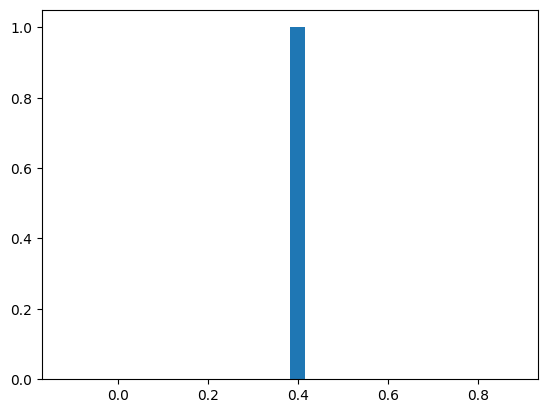

In [ ]:
return_articles = get_articles_sentiments(keywrd= 'AMZN', startd = '07-Dec-2022', sources_list = None, show_all_articles= True)
return_articles.Sentiment.hist(bins=30,grid=False)

print(return_articles.Sentiment.mean())
print(return_articles.Sentiment.count())
print(return_articles.Description)

In [ ]:
return_articles.sort_values(by='Sentiment', ascending=True)[['Sentiment','URL']].head(2)

,Sentiment,URL
0,0.3818,https://www.marketbeat.com/originals/top-10-se...


# Gathering Data From AlphaAdvantage for Historical News #

In [2]:
from decouple import config
import requests
import urllib.parse
AAapikey = config('AAKey')

In [3]:
r = requests.get(url)
data = r.json()

{'items': '50', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': 'Shopify Is Innovating Across All Stripes In an Effort To Slash Costs - Shopify  ( NYSE:SHOP ) , Apple  ( NASDAQ:AAPL ) , Amazon.com  ( NASDAQ:AMZN ) ', 'url': 'https://www.benzinga.com/general/23/01/30334417/shopify-is-innovating-across-all-stripes-in-an-effort-to-slash-costs', 'time_published': '20230109T182523', 'authors': ['Upwallstreet'], 'summary': "Rising inflation and higher interest rates are weakening consumers' buying power and consequently, e-commerce purchases are dropping.", 'banner_image': 'https://cdn.benzinga.com/files/images/story/2023/01/09/screen_shot_2023-01-05_at_1.36.34_pm.png?width=1200&height=800&fit=crop', 'source': 'Benzinga', 'category_within_source': 'General'

In [57]:
#Function to convert user provided date to date required by AlphaAdvantage
def toAADate(oldDate):
    newDate = str(oldDate) + 'T0001'
    return newDate

In [64]:
# Get data from AlphaAdvantage for one ticker for a particular day
def getHistoricNewsData(ticker, startDate = None, endDate = None):
    url = 'https://www.alphavantage.co/query?'
    if startDate and endDate:
        startDate = toAADate(startDate)
        endDate = toAADate(endDate)
        Myparams = {'function': 'NEWS_SENTIMENT', 'tickers': ticker, 'time_from': startDate, 'time_to': endDate, 'sort': 'LATEST','limit': 100, 'apikey': AAapikey}
    else:
        Myparams = {'function': 'NEWS_SENTIMENT', 'tickers': ticker, 'sort': 'LATEST','limit': 100, 'apikey': AAapikey}
    r = requests.get(url, params = Myparams)
    date = r.json()
    print(data)

getHistoricNewsData('AAPL', '20221101', '20230109')

{'items': '50', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': 'Shopify Is Innovating Across All Stripes In an Effort To Slash Costs - Shopify  ( NYSE:SHOP ) , Apple  ( NASDAQ:AAPL ) , Amazon.com  ( NASDAQ:AMZN ) ', 'url': 'https://www.benzinga.com/general/23/01/30334417/shopify-is-innovating-across-all-stripes-in-an-effort-to-slash-costs', 'time_published': '20230109T182523', 'authors': ['Upwallstreet'], 'summary': "Rising inflation and higher interest rates are weakening consumers' buying power and consequently, e-commerce purchases are dropping.", 'banner_image': 'https://cdn.benzinga.com/files/images/story/2023/01/09/screen_shot_2023-01-05_at_1.36.34_pm.png?width=1200&height=800&fit=crop', 'source': 'Benzinga', 'category_within_source': 'General'

# Sentiment Analysis of FinViz data #

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ishaan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [ ]:
# View Data 
#news = pd.DataFrame()
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



              Date     Time    neg    neu    pos  compound
Ticker                                                    
AAPL    2023-01-06  06:48PM  0.000  1.000  0.000    0.0000
AAPL    2023-01-06  06:43PM  0.209  0.791  0.000   -0.4404
AAPL    2023-01-06  05:15PM  0.209  0.791  0.000   -0.4404
AAPL    2023-01-06  04:09PM  0.000  0.852  0.148    0.5106
AAPL    2023-01-06  04:00PM  0.000  0.722  0.278    0.6597


              Date     Time    neg    neu    pos  compound
Ticker                                                    
TSLA    2023-01-06  10:26PM  0.000  0.751  0.249    0.5106
TSLA    2023-01-06  09:01PM  0.205  0.795  0.000   -0.4767
TSLA    2023-01-06  07:45PM  0.000  1.000  0.000    0.0000
TSLA    2023-01-06  07:30PM  0.206  0.794  0.000   -0.5994
TSLA    2023-01-06  06:31PM  0.000  0.737  0.263    0.3612


              Date     Time   neg    neu    pos  compound
Ticker                                                   
AMZN    2023-01-06  06:48PM  0.00  1.000  0.000    0

In [ ]:
#Testing helper functions from stock_helper_functions.ipynb
aapl_open = getStockOpen("AAPL")

Getting stock open for stock $AAPL
AAPL 126.01000213623047


# Creating Dataset #

In [ ]:
num = df.loc['AMZN']
num

Mean Sentiment   -0.08
Name: AMZN, dtype: float64

In [ ]:
#Pulling stock data
for i in tickers:
    dataset = getStockDataDaily(i, day='2022-12-27')
    dataset['Sentiment'] = float(df.loc[i])
    #print(dataset)
    

Getting stock data for stock $AAPL
[*********************100%***********************]  1 of 1 completed
Getting stock data for stock $TSLA
[*********************100%***********************]  1 of 1 completed
Getting stock data for stock $AMZN
[*********************100%***********************]  1 of 1 completed
